In [85]:
# Stuff used previously:

import pandas as pd
import numpy as np
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

dfs = pd.read_excel("Acme.xlsx")

dfs_copy = dfs.copy()


from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
oversample = SMOTE()


X = dfs_copy[['currently_insured', 'number_of_vehicles', 'number_of_drivers', 'marital_status','rank']]
y = dfs_copy['policies sold']
X.loc[X.currently_insured == "Y",'currently_insured'] = 1
X.loc[X.currently_insured == "N",'currently_insured'] = 0
X.loc[X.marital_status == "M",'marital_status'] = 1
X.loc[X.marital_status == "S",'marital_status'] = 0
# First we try clustering:

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
dfs_copy.head()

c:\python3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,impression_id,click,cost,currently_insured,number_of_vehicles,number_of_drivers,marital_status,rank,policies sold
0,1,1,10,N,1,1,M,1,1
1,2,0,10,N,2,1,M,4,0
2,3,0,10,N,1,1,S,2,0
3,4,0,10,Y,2,1,M,5,0
4,5,0,10,Y,2,2,S,4,0


In [86]:
Z = linkage(X, 'centroid')

clustersh = fcluster(Z, t=2, criterion='maxclust')


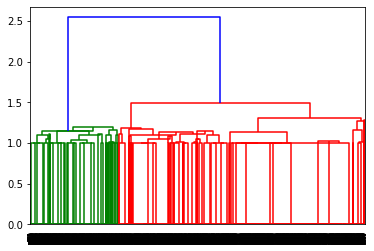

In [59]:
dendrogram(Z)

plt.show()

In [87]:
clustersh

array([1, 2, 1, ..., 2, 2, 1], dtype=int32)

In [88]:
kmeans = KMeans(2)                   # 2 for the number of policies sold

kmeans.fit(X)
clusters = kmeans.predict(X)

In [89]:
clusters

array([0, 1, 0, ..., 1, 1, 0])

In [67]:
count = 0
for i in range(10000):
    if clusters[i] != dfs_copy.loc[i, 'policies sold']:
        count = count + 1
    
count1 = 0
for i in range(10000):
    if clustersh[i] - 1 != dfs_copy.loc[i, 'policies sold']:
        count1 = count1 + 1
    
print(count)    # 5381
print(count1)   # 7609

# this don't necessarily measure anything since cluster[i] or clusterh[i] 
# could be any policies sold, not just policies sold of index i.
# So we check if clusters[i] and clustersh[i] are the same as dfs_copy[i,'policies sold'] in any modulo class
# 


count = 0
for i in range(10000):
    if clusters[i] != (dfs_copy.loc[i, 'policies sold']+1)%2:
        count = count + 1
    
count1 = 0
for i in range(10000):
    if clustersh[i] - 1 != (dfs_copy.loc[i, 'policies sold']+1)%2:
        count1 = count1 + 1
    
print(count)    # 4619
print(count1)   # 2391

# This one above seems to do best, so policies sold = clusters(h) + 1 (mod 2).


5381
7609
4619
2391


In [ ]:
# accuracy for kmeans (k = 2) = (10000 - 4619)/10000 = 5381/10000 = .5381 or 53.81%
# accuracy for hierarchical clustering = (10000 - 2391)/10000 = .7609 = 76.09%

# Accuracy for either clustering method on y = rank (X = usual 4 variables) was too poor to consider here.

In [90]:
# Now we'll try PCA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 'click'? Don't include this.
X = dfs_copy[['currently_insured', 'number_of_vehicles', 'number_of_drivers', 'marital_status','rank']]
y = dfs_copy['policies sold']
X.loc[X.currently_insured == "Y",'currently_insured'] = 1
X.loc[X.currently_insured == "N",'currently_insured'] = 0
X.loc[X.marital_status == "M",'marital_status'] = 1
X.loc[X.marital_status == "S",'marital_status'] = 0

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .25,random_state = 614,shuffle = True,stratify = y)

# At the moment, X is 6-dimensional. 
# we'll project down to 2-D ???
#pca = PCA(n_components = 2)

pca_pipe = Pipeline([('scaler',StandardScaler()),
                ('pca',PCA(n_components=2))])

# Fit the data
#X_pca = pca.fit_transform(X_train)
X_pca = pca_pipe.fit_transform(X_train)


c:\python3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


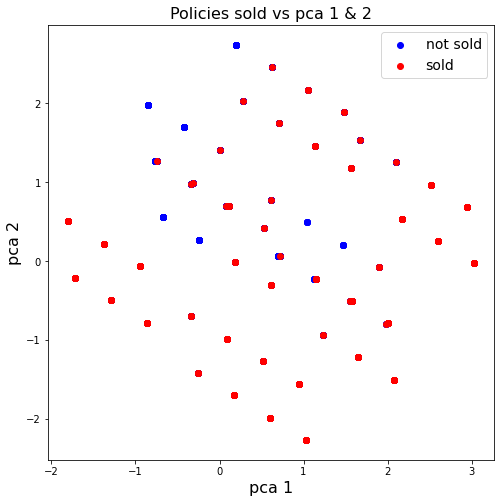

In [91]:
plt.figure(figsize = (8,8))

plt.scatter(X_pca[y_train==0,0],X_pca[y_train==0,1],c='blue',label='not sold')
plt.scatter(X_pca[y_train==1,0],X_pca[y_train==1,1],c='red',label='sold')

plt.legend(fontsize=14)
plt.title("Policies sold vs pca 1 & 2",fontsize=16)
plt.xlabel("pca 1",fontsize=16)
plt.ylabel("pca 2",fontsize=16)

plt.show()

In [92]:

pca_pipe = Pipeline([('scaler',StandardScaler()),
                ('pca',PCA(n_components=5))])


X_pca = pca_pipe.fit_transform(X_train)


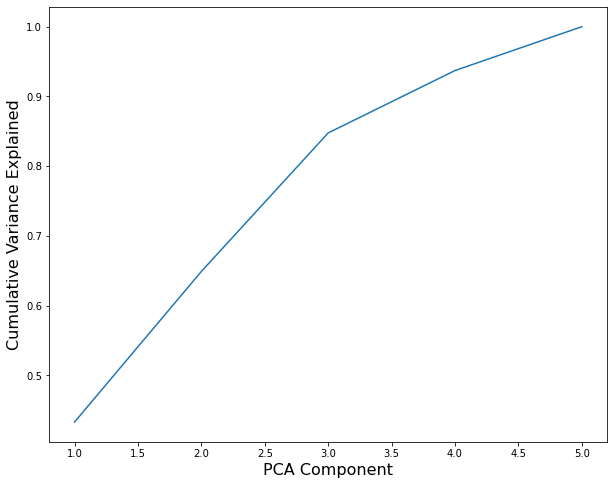

In [93]:
plt.figure(figsize=(10,8))

plt.plot(range(1,6),
        np.cumsum(pca_pipe.named_steps['pca'].explained_variance_ratio_))

plt.xlabel("PCA Component", fontsize=16)
plt.ylabel("Cumulative Variance Explained", fontsize=16)

plt.show()


In [94]:
# Not much of an apparent bump in this graph, maybe at components = 4, but it's not as pronounced as usual.

pca_pipe2 = Pipeline([('scaler',StandardScaler()),
                ('pca',PCA(n_components=0.582))])

# 2 components explains up to 58.2% of variance

X_pca2 = pca_pipe2.fit_transform(X_train)
np.shape(X_pca2)

(7500, 2)